In [1]:
# credit 
# https://github.com/pytorch/examples/tree/master/time_sequence_prediction

In [32]:
import numpy as np
import torch

from __future__ import print_function
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline


Populating the interactive namespace from numpy and matplotlib


/Users/yennanliu/anaconda3/envs/pytorch_/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['draw']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [8]:
# help functions 

def generate_data():
    np.random.seed(2)
    T = 20
    L = 1000
    N = 100

    x = np.empty((N, L), 'int64')
    x[:] = np.array(range(L)) + np.random.randint(-4 * T, 4 * T, N).reshape(N, 1)
    data = np.sin(x / 1.0 / T).astype('float64')
    torch.save(data, open('traindata.pt', 'wb'))
    
    
class Sequence(nn.Module):
    def __init__(self):
        super(Sequence, self).__init__()
        self.lstm1 = nn.LSTMCell(1, 51)
        self.lstm2 = nn.LSTMCell(51, 51)
        self.linear = nn.Linear(51, 1)

    def forward(self, input, future = 0):
        outputs = []
        h_t = Variable(torch.zeros(input.size(0), 51).double(), requires_grad=False)
        c_t = Variable(torch.zeros(input.size(0), 51).double(), requires_grad=False)
        h_t2 = Variable(torch.zeros(input.size(0), 51).double(), requires_grad=False)
        c_t2 = Variable(torch.zeros(input.size(0), 51).double(), requires_grad=False)

        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs += [output]
        for i in range(future):# if we should predict the future
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs += [output]
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs



## 0) Get data 

In [9]:
# generate data 
generate_data()

## 1) Train

In [13]:
np.random.seed(0)
torch.manual_seed(0)
# load data and make training set
data = torch.load('traindata.pt')
input = Variable(torch.from_numpy(data[3:, :-1]), requires_grad=False)
target = Variable(torch.from_numpy(data[3:, 1:]), requires_grad=False)
test_input = Variable(torch.from_numpy(data[:3, :-1]), requires_grad=False)
test_target = Variable(torch.from_numpy(data[:3, 1:]), requires_grad=False)
# build the model
seq = Sequence()
seq.double()
criterion = nn.MSELoss()
# use LBFGS as optimizer since we can load the whole data to train
optimizer = optim.LBFGS(seq.parameters(), lr=0.8)
#begin to train
for i in range(15):
    print('STEP: ', i)
    def closure():
        optimizer.zero_grad()
        out = seq(input)
        loss = criterion(out, target)
        print('loss:', loss.data.numpy()[0])
        loss.backward()
        return loss
    optimizer.step(closure)
    # begin to predict
    future = 1000
    pred = seq(test_input, future = future)
    loss = criterion(pred[:, :-future], test_target)
    print('test loss:', loss.data.numpy()[0])
    y = pred.data.numpy()
    # draw the result
    plt.figure(figsize=(30,10))
    plt.title('Predict future values for time sequences\n(Dashlines are predicted values)', fontsize=30)
    plt.xlabel('x', fontsize=20)
    plt.ylabel('y', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    def draw(yi, color):
        plt.plot(np.arange(input.size(1)), yi[:input.size(1)], color, linewidth = 2.0)
        plt.plot(np.arange(input.size(1), input.size(1) + future), yi[input.size(1):], color + ':', linewidth = 2.0)
    draw(y[0], 'r')
    draw(y[1], 'g')
    draw(y[2], 'b')
    #plt.savefig('predict%d.pdf'%i)
    #plt.close()

STEP:  0
loss: 0.5023738122475343
loss: 0.4985663937943548
loss: 0.47901196061153795
loss: 0.44633490214842314
loss: 0.35406310257493745
loss: 0.2050701661768059
loss: 1.3960531561171134
loss: 0.03249441148472099
loss: 0.02993487583960186
loss: 0.02832682101153434
loss: 0.026830612218824906
loss: 0.023771201989990658
loss: 0.018901413504546632
loss: 0.01064681823320781
loss: 0.008725752090268534
loss: 0.00787218128777712
loss: 0.005477842749594931
loss: 0.004051933564064742
loss: 0.0027296227011606292
loss: 0.0015402652769816148
test loss: 0.0013000876156958965
STEP:  1
loss: 0.0012797646167829876
loss: 0.0011690554954717567
loss: 0.0011498916013728058
loss: 0.0011288245291280817
loss: 0.0010630561341021738
loss: 0.0009564006443276662
loss: 0.0008210827589977255
loss: 0.0007670796029152806
loss: 0.0007294716423581975
loss: 0.0007246558169814497
loss: 0.0007206211393653245
loss: 0.000712668605311216
loss: 0.0006961310498776816
loss: 0.0006641101811552423
loss: 0.0006101210702290394
loss

loss: 3.852741492359847e-06
loss: 3.836800524040158e-06
loss: 3.830137372799062e-06
test loss: 6.520707126381636e-06


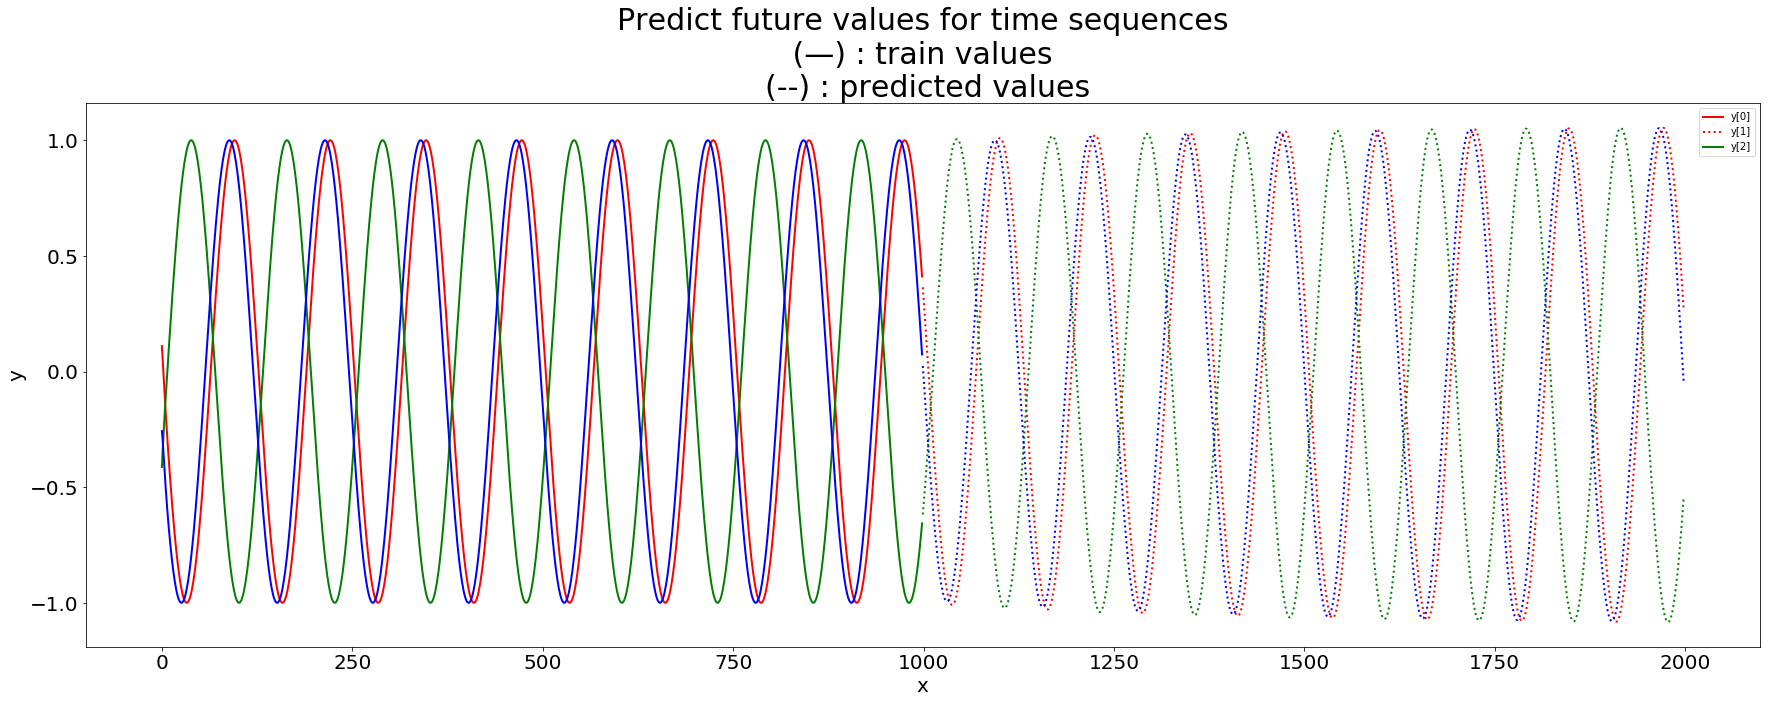

In [41]:
plt.figure(figsize=(30,10))
plt.title('Predict future values for time sequences\n (—) : train values \n  (--) : predicted values ', fontsize=30)
plt.xlabel('x', fontsize=20)
plt.ylabel('y', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

def draw(yi, color):

    plt.plot(np.arange(input.size(1)), yi[:input.size(1)], color, linewidth = 2.0)
    plt.plot(np.arange(input.size(1), input.size(1) + future), yi[input.size(1):], color + ':', linewidth = 2.0)
    plt.legend(['y[0]','y[1]','y[2]' ])
draw(y[0], 'r')
draw(y[1], 'g')
draw(y[2], 'b')